In [1]:
import os
import numpy as np
import sklearn as sk
#from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
#from keras.preprocessing.image import ImageDataGenerator
#from keras.utils import image_dataset_from_directory
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam
#from keras import mixed_precision
from keras import backend as K
from keras.metrics import binary_crossentropy
import unets_repo
from scipy.ndimage import convolve

In [2]:
keras.backend.clear_session()

In [3]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

#mixed_precision.set_global_policy('mixed_float16')
#os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"
#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

True


In [4]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

In [22]:
batch_size = 5

---


In [6]:
def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [7]:
def batch_generator(suj_path, mask_path):
    suj_files = os.listdir(suj_path)
    indices = np.arange(len(suj_files))
    indices = np.random.permutation(indices)
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch=[]

In [8]:
train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))

In [9]:
x,y = train_gen_ds.__next__()

In [10]:
print(x)

[[[ 1.05735074e+00  9.22384882e-01  8.72969683e-01 ...  8.75043860e-01
    9.37147770e-01  5.92996124e-01]
  [ 6.81009374e-01  6.59121198e-01  1.09825286e+00 ...  1.11424888e+00
    1.02524645e+00  6.40499910e-01]
  [ 7.23212298e-01  8.32845725e-01  8.61899926e-01 ...  1.05674787e+00
    9.17902486e-01  5.23792867e-01]
  ...
  [-1.39320171e+00 -1.17863641e+00 -1.12200574e+00 ... -9.69683244e-01
   -6.40491150e-01 -3.43676661e-01]
  [-1.24232876e+00 -1.38100878e+00 -1.44534388e+00 ... -8.00157063e-01
   -3.50077251e-01 -8.09019172e-02]
  [-1.26124974e+00 -1.34595385e+00 -1.29330968e+00 ... -6.06175993e-01
   -3.99132017e-01 -2.19223212e-01]]

 [[-1.25944221e+00 -1.35842922e+00 -1.42532113e+00 ... -1.14103363e+00
   -1.08605224e+00 -1.23303557e+00]
  [-1.22812104e+00 -1.31761314e+00 -1.40104032e+00 ... -1.11431297e+00
   -1.05898054e+00 -1.21295079e+00]
  [-1.14177339e+00 -1.21263329e+00 -1.27853299e+00 ... -1.08465482e+00
   -1.02141860e+00 -1.16998421e+00]
  ...
  [-7.40150650e-01 -6.3

In [11]:
print(x.shape)
print(y.shape)
print(x.max(),x.min())
print(y.max(),y.min())

(6, 256, 256)
(6, 256, 256)
13.376493072300716 -1.7145092197706386
1.2324629199533885 -0.22892629684349314


<function matplotlib.pyplot.show(close=None, block=None)>

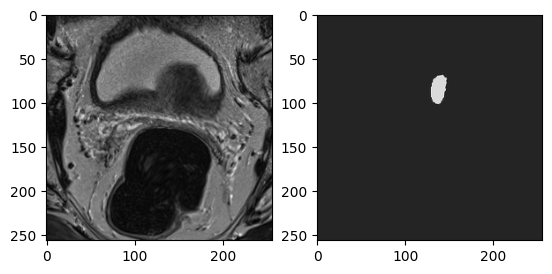

In [12]:
x,y = val_gen_ds.__next__()
image = x[0,:,:]
mask = y[0,:,:]
plt.subplot(1,2,1)
plt.imshow(image,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(mask,cmap="gray")
plt.show

In [23]:
n_train_img = len(os.listdir(os.path.join(fp1,"sujetos"))) #si es para npy saco "img"
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
print(n_train_img,n_val_img)
spe = n_train_img//batch_size 
vspe = n_val_img//batch_size

4003 1228


---


In [14]:
my_unet = unets_repo.AttUnet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
#print(my_unet.summary())

In [15]:
def Dice(targets, inputs):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + K.epsilon()) / (K.sum(targets) + K.sum(inputs) + K.epsilon())

def Jaccard(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + K.epsilon())/(union + K.epsilon())

def DiceBCELoss(targets, inputs):    
    
    BCE =  K.mean(binary_crossentropy(targets, inputs))
    
    return BCE + 1 - Dice(targets, inputs)

def FocalLoss(targets, inputs, alpha=0.8, gamma=2):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.mean(binary_crossentropy(targets, inputs))
    BCE_EXP = K.exp(-BCE)
    
    return alpha * K.pow((1-BCE_EXP), gamma) * BCE

def DiceLoss(targets, inputs):    
    
    return 1 - Dice(targets, inputs)




In [18]:
# from skimage.measure import label, regionprops
# from scipy.spatial.distance import directed_hausdorff

# # Calculate the Hausdorff distance between two binary images
# def hausdorff_distance(y_true, y_pred):
#     # Extract the connected components from the images
#     true_labels = label(y_true)
#     pred_labels = label(y_pred)
    
#     # Convert the images to sets of points
#     true_points = [region.coords for region in regionprops(true_labels)]
#     pred_points = [region.coords for region in regionprops(pred_labels)]
    
#     # Calculate the directed Hausdorff distance between the sets of points
#     distance = directed_hausdorff(true_points, pred_points)[0]
    
#     return distance

In [17]:
# def scheduler(epoch, lr):
#     if epoch < 5:
#         return lr
#     initial_lr = 0.01
#     decay = 0.95
#     return initial_lr * decay ** epoch
# def scheduler(epoch, lr):
#     if epoch < 5:
#         return 0.001
#     return 0.0005

In [16]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True,monitor="val_Dice",mode="max"),
    tf.keras.callbacks.ModelCheckpoint(filepath='modelsh5/{val_Dice:.4f}_attunet_relu_aug_dicebce.h5',save_best_only=True,save_weights_only=True,monitor="val_Dice",mode="max"),
    #tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_Dice', mode="max", factor=0.75,patience=5, min_lr=0.00001,min_delta=0.005)
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [17]:
#optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate = 1e-3))
optimizer = Adam(learning_rate = 5e-4)

In [21]:
#my_unet = keras.models.load_model("modelsh5/unet_model.00-0.0166-0.7759_base_focal_.h5",custom_objects={"DiceBCE":DiceBCE,"DiceBCELoss":DiceBCELoss,"FocalLoss":FocalLoss})

In [28]:
my_unet.load_weights("modelsh5/0.8042_attunet_relu_aug_dicebce.h5")

In [20]:
my_unet.compile(optimizer = optimizer, loss = DiceBCELoss, metrics = [Dice,Jaccard,keras.metrics.Precision(),keras.metrics.Recall()])

In [24]:
history = my_unet.fit(train_gen_ds,
                    verbose=1, 
                    steps_per_epoch=spe,
                    epochs=100,
                    validation_data=val_gen_ds, 
                    validation_steps=vspe,
                    callbacks=my_callbacks)

Epoch 1/100
800/800 [==============================] - 378s 465ms/step - loss: 0.1252 - Dice: 0.8885 - Jaccard: 0.8379 - precision: 0.9663 - recall: 0.3829 - val_loss: 0.7901 - val_Dice: 0.3000 - val_Jaccard: 0.1839 - val_precision: 0.9988 - val_recall: 0.0426 - lr: 5.0000e-04
Epoch 2/100
800/800 [==============================] - 349s 437ms/step - loss: 0.1216 - Dice: 0.8927 - Jaccard: 0.8416 - precision: 0.9622 - recall: 0.3836 - val_loss: 0.4114 - val_Dice: 0.6409 - val_Jaccard: 0.5020 - val_precision: 0.9740 - val_recall: 0.2572 - lr: 5.0000e-04
Epoch 3/100
800/800 [==============================] - 320s 400ms/step - loss: 0.1170 - Dice: 0.8949 - Jaccard: 0.8502 - precision: 0.9699 - recall: 0.3853 - val_loss: 0.9136 - val_Dice: 0.1978 - val_Jaccard: 0.1132 - val_precision: 0.9999 - val_recall: 0.0077 - lr: 5.0000e-04
Epoch 4/100
800/800 [==============================] - 309s 386ms/step - loss: 0.1065 - Dice: 0.9044 - Jaccard: 0.8616 - precision: 0.9717 - recall: 0.3867 - val_loss

KeyboardInterrupt: 

In [25]:
#my_unet.save("modelsh5/unet_model.0.8199_att_unet_small_relu_he_aug.h5")

In [24]:
#my_unet.evaluate(val_gen_ds,batch_size=6,steps=spe)

667/667 [==============================] - 73s 109ms/step - loss: 0.1856 - Dice: 0.8144 - Jaccard: 0.7122 - precision: 0.9219 - recall: 0.3505


[0.18559962511062622,
 0.8144001364707947,
 0.7121899127960205,
 0.9218932390213013,
 0.3504602909088135]

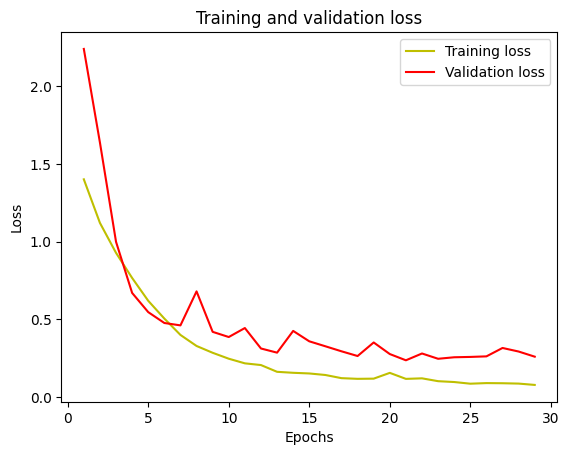

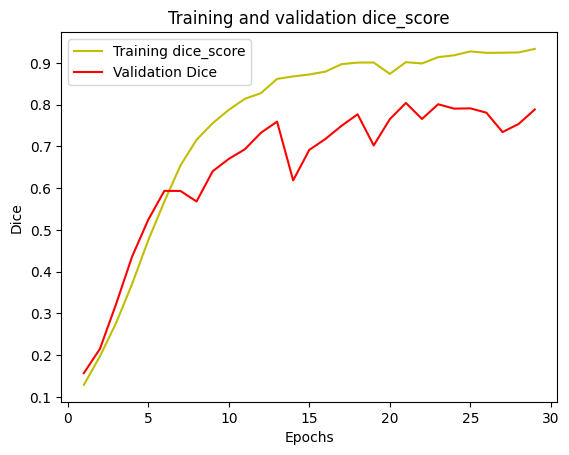

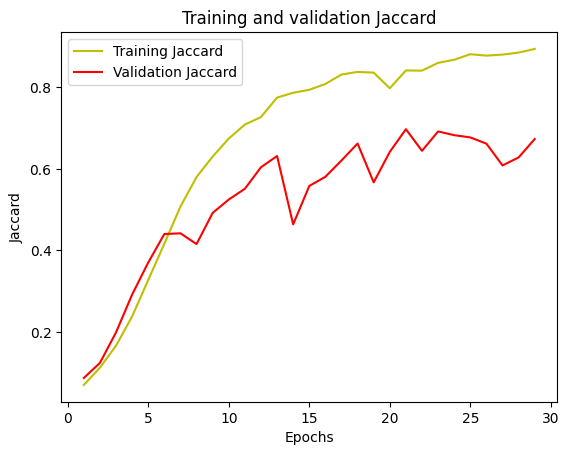

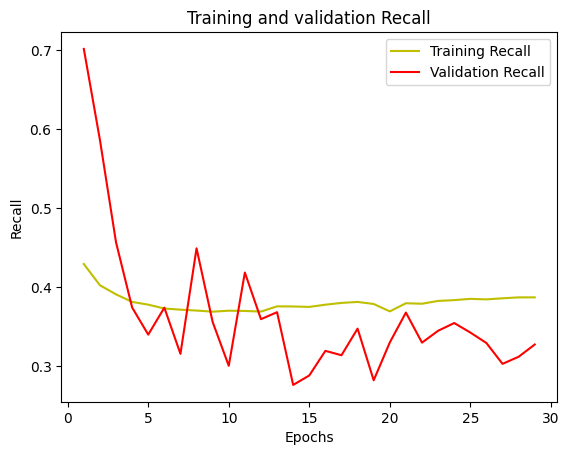

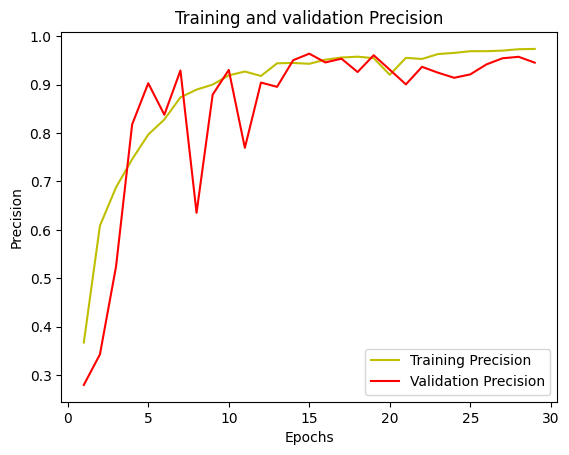

In [22]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Dice']
val_acc = history.history['val_Dice']

plt.plot(epochs, acc, 'y', label='Training dice_score')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

acc2 = history.history['Jaccard']
val_acc2 = history.history['val_Jaccard']

plt.plot(epochs, acc2, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc2, 'r', label='Validation Jaccard')
plt.title('Training and validation Jaccard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard')
plt.legend()
plt.show()

rec2 = history.history['recall']
val_rec2 = history.history['val_recall']

plt.plot(epochs, rec2, 'y', label='Training Recall')
plt.plot(epochs, val_rec2, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

pre2 = history.history['precision']
val_pre2 = history.history['val_precision']

plt.plot(epochs, pre2, 'y', label='Training Precision')
plt.plot(epochs, val_pre2, 'r', label='Validation Precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

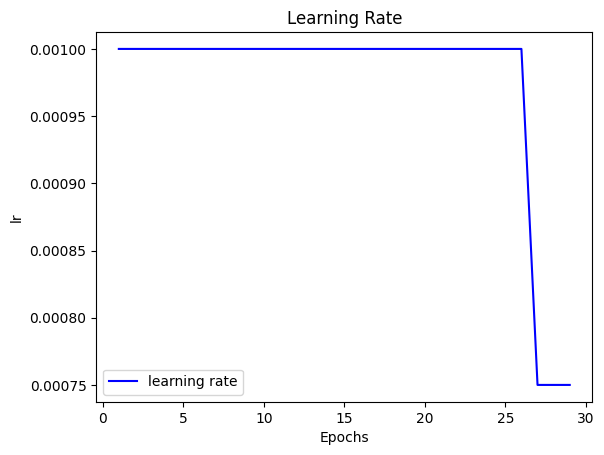

In [18]:
lrr = history.history['lr']

plt.plot(epochs, lrr, 'b', label='learning rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

In [25]:
def Dice(targets, inputs):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + K.epsilon()) / (K.sum(targets) + K.sum(inputs) + K.epsilon())

def Jaccard(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    
    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + K.epsilon())/(union + K.epsilon())

In [26]:
batch_size = 1
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
vspe = n_val_img//batch_size

In [25]:
my_unet = unets_repo.AttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
my_unet.load_weights("modelsh5/0.8160_attunet_selu_lecun_aug_dicebce.h5")

In [29]:
my_unet = unets_repo.unet3plus(input_size=(256,256,1))
my_unet.load_weights("modelsh5/0.5662_unet3plus_relu_aug_dicebce.h5")

In [21]:
my_unet = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=16)
my_unet.load_weights("modelsh5/0.8174_unet_v_small_selu_lecun_aug_dice.h5")


In [19]:
my_unet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=32)
my_unet.load_weights("modelsh5/0.7947_unet_small_relu_he_aug.h5")

In [23]:
my_unet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
my_unet.load_weights("modelsh5/0.8134_unet_relu_he_aug.h5")

In [17]:
my_unet = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
my_unet.load_weights("modelsh5/0.8314_unet_selu_lecun_aug_dicebce.h5")

In [27]:
my_unet = unets_repo.ResAttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
my_unet.load_weights("modelsh5/0.7741_resattunet_selu_lecun_aug_dicebce.h5")

In [15]:
my_unet = unets_repo.classicUNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
my_unet.load_weights("modelsh5/0.8233_classicunet_selu_lecun_aug_dicebce.h5")

In [29]:
dice = 0
jac = 0
for _ in range(0,vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    for i in range(test_image_batch.shape[0]):
        a = my_unet(np.expand_dims(test_image_batch[i], 0)).numpy()
        predicted_img_th = (a[0,:,:,0]>0.5)*1
        dice += Dice(test_mask_batch[i],predicted_img_th).numpy()
        jac += Jaccard(test_mask_batch[i],predicted_img_th).numpy()
print(dice/n_val_img)
print(jac/n_val_img)

0.8278159251308763
0.7876201128699118


In [46]:
my_unet.compile(optimizer = optimizer, loss = DiceBCELoss, metrics = [Dice,Jaccard,keras.metrics.Precision(),keras.metrics.Recall()])
my_unet.evaluate(val_gen_ds,batch_size=batch_size,steps=vspe)

614/614 [==============================] - 128s 194ms/step - loss: 0.4620 - Dice: 0.5968 - Jaccard: 0.5184 - precision_4: 0.9194 - recall_4: 0.3187


[0.4620059132575989,
 0.5967908501625061,
 0.5184403657913208,
 0.9193821549415588,
 0.31865763664245605]

In [49]:
iou = 0
IOU_keras = MeanIoU(num_classes=2)  
for i in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    #test_img_number = random.randint(0, len(test_image_batch)-1)
    for test_img_number in range(0, len(test_image_batch)):
        test_img = test_image_batch[test_img_number]
        ground_truth = test_mask_batch[test_img_number]
        test_img_norm = test_img[:,:]
        test_img_input = np.expand_dims(test_img_norm, 0)
        prediction = my_unet.predict(test_img_input,verbose=0)
        predicted_img_th = prediction[0,:,:,0]>0.5
        IOU_keras.update_state(ground_truth, predicted_img_th)
        iou += IOU_keras.result().numpy()
print("Mean IOU: ", iou/(vspe*batch_size))

Mean IOU:  0.8329079591393083


1/1 [==============================] - 0s 20ms/step
Mean IoU = 0.9635917


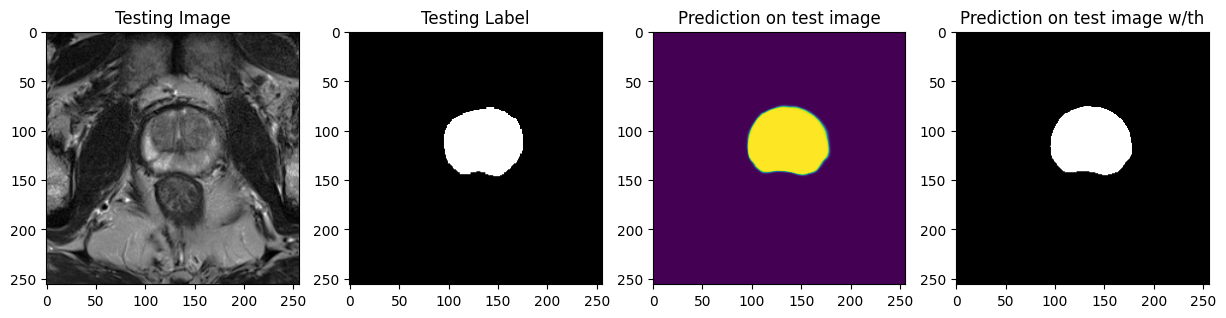

In [58]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
test_img_norm=test_img[:,:]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (my_unet.predict(test_img_input))
predicted_img_th = prediction[0,:,:,0]>0.5

IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_img_th)
print("Mean IoU =", IOU_keras.result().numpy())

plt.figure(figsize=(15, 10))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,0])
plt.subplot(244)
plt.title('Prediction on test image w/th')
plt.imshow(predicted_img_th, cmap='gray')
plt.show()

In [59]:
with open('history_atteunet_relu_he_dicebce.txt', 'w') as f:
    print(history.history, file=f)

In [144]:
my_unet.layers[22]

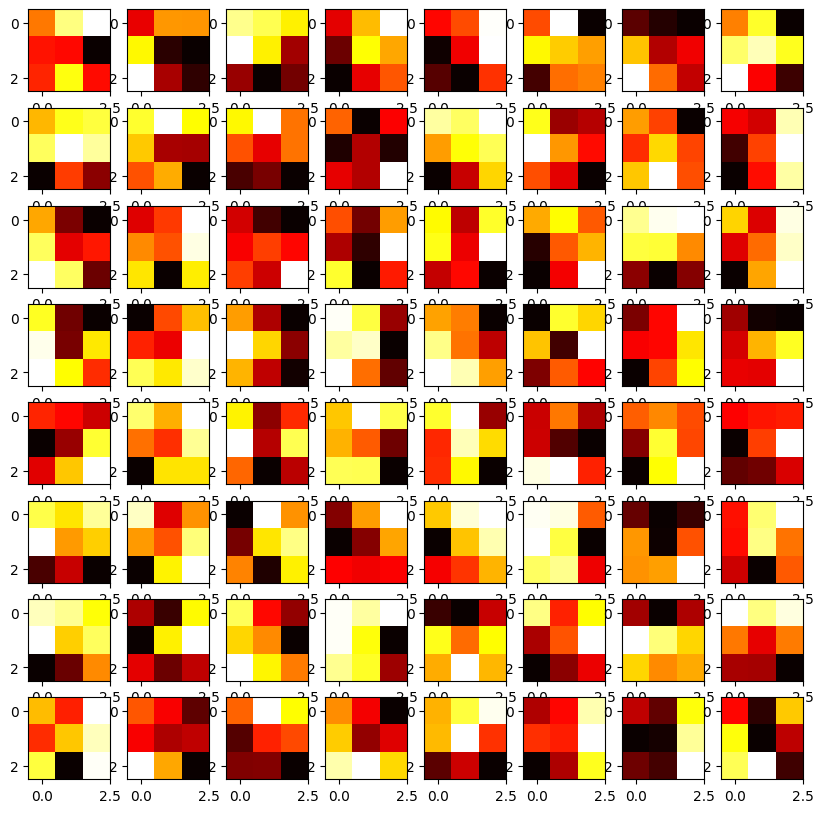

In [65]:
plt.figure(figsize=(10,10))
for i in range(64):
    filter = my_unet.layers[8].get_weights()[0][:,:,0,i]
    plt.subplot(8,8,i+1)
    plt.imshow(filter,cmap="hot")
plt.show()

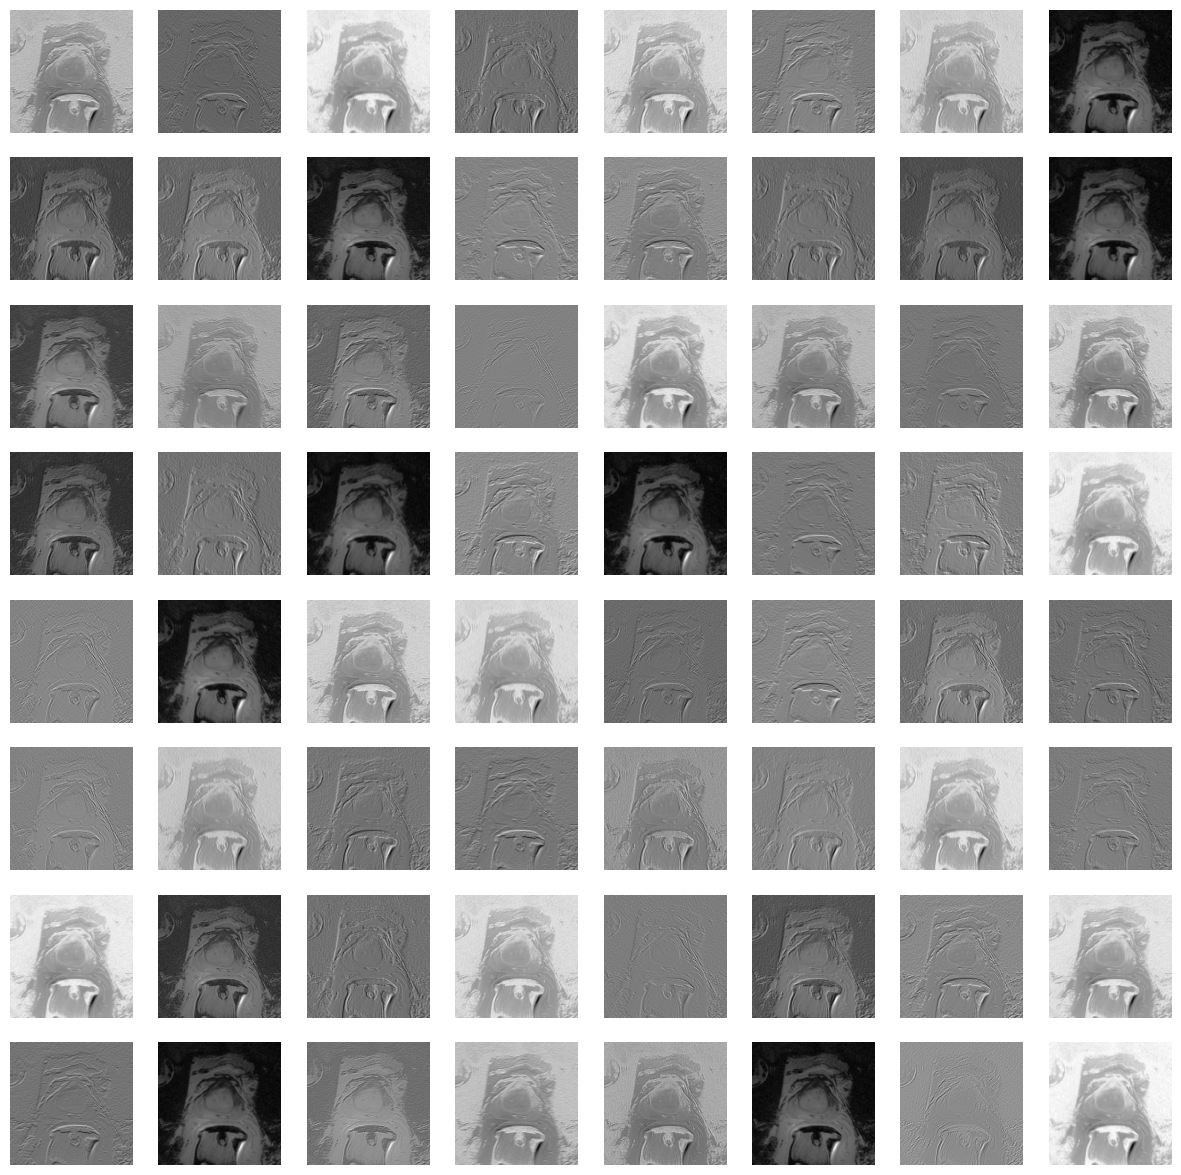

In [49]:
x,y = train_gen_ds.__next__()
image = x[0,::]
plt.figure(figsize=(15,15))
for i in range(64):
    filter = my_unet.layers[1].get_weights()[0][:,:,0,i]
    filtered_image = convolve(image, filter)
    plt.subplot(8,8,i+1)
    plt.imshow(filtered_image,cmap="gray")
    plt.axis("off")
plt.show()